In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import random
import time
from typing import List, Tuple

# Google Drive'a bağlanma
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Sabitler ve Hiperparametreler
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılacak cihaz: {DEVICE}")

# Model Mimarisi Parametreleri
D_MODEL = 512
N_HEAD = 8
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DIM_FEEDFORWARD = 1024
DROPOUT = 0.1
ACTIVATION_FN_STR = "relu" # nn.TransformerEncoderLayer/DecoderLayer bunu doğrudan kabul eder
MAX_SEQ_LEN = 50

# Eğitim Hiperparametreleri
BATCH_SIZE = 512
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100
CLIP_GRAD = 1.0
MIN_VOCAB_FREQ = 2
SAVE_LOG_INTERVAL = 1

# Erken Durdurma Parametreleri
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

# LR Scheduler Parametreleri
SCHEDULER_PATIENCE = 5
SCHEDULER_FACTOR = 0.1

# Dosya Yolları
DRIVE_BASE_PATH = '/content/drive/My Drive/transformer/'
TRAIN_DATA_FILE_NAME = 'en2tr_train.txt'
VALID_DATA_FILE_NAME = 'en2tr_valid.txt'
MODEL_CHECKPOINT_DIR_NAME = 'model_checkpoints'
LAST_CHECKPOINT_FILE_NAME = 'last_checkpoint_512.pth'
BEST_MODEL_FILE_NAME = 'best_model_512.pth'

TRAIN_FILE_PATH = os.path.join(DRIVE_BASE_PATH, TRAIN_DATA_FILE_NAME)
VALID_FILE_PATH = os.path.join(DRIVE_BASE_PATH, VALID_DATA_FILE_NAME)
CHECKPOINT_DIR = os.path.join(DRIVE_BASE_PATH, MODEL_CHECKPOINT_DIR_NAME)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, BEST_MODEL_FILE_NAME)
LAST_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, LAST_CHECKPOINT_FILE_NAME)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)

# SINIFLAR
class WordTokenizer:
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
        self.min_freq = 1

    def build_vocab(self, sentences: List[str], min_freq: int = 1):
        self.min_freq = min_freq
        word_counts = {}
        for sentence in sentences:
            for word in sentence.split():
                word_counts[word] = word_counts.get(word, 0) + 1

        newly_added_count = 0
        for word, count in word_counts.items():
            if count >= self.min_freq and word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                newly_added_count +=1
        self.vocab_size = len(self.word2idx)
        print(f"Kelime dağarcığı oluşturuldu. Eklenen yeni kelime: {newly_added_count}. Toplam boyut: {self.vocab_size}")

    def encode(self, sentence: str, add_sos_eos: bool = False) -> List[int]:
        tokens = [self.word2idx.get(word, self.word2idx['<unk>']) for word in sentence.split()]
        if add_sos_eos:
            tokens = [self.word2idx['<sos>']] + tokens + [self.word2idx['<eos>']]
        return tokens

    def decode(self, indices: List[int]) -> str:
        return ' '.join([self.idx2word.get(idx, '<unk>') for idx in indices if idx not in [self.word2idx['<pad>'], self.word2idx['<sos>'], self.word2idx['<eos>']]])

class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, padding_idx: int = None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
        self.embedding_dim = embedding_dim
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term)[:,:d_model//2]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size: int, trg_vocab_size: int,
                 src_pad_idx: int, trg_pad_idx: int,
                 d_model: int, nhead: int,
                 num_encoder_layers: int, num_decoder_layers: int,
                 dim_feedforward: int, dropout: float,
                 activation_fn_str: str, max_seq_len: int):
        super().__init__()
        self.d_model = d_model
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.src_embedding = Embedding(src_vocab_size, d_model, padding_idx=src_pad_idx)
        self.trg_embedding = Embedding(trg_vocab_size, d_model, padding_idx=trg_pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=max_seq_len)

        self.transformer = nn.Module()

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation_fn_str, # "relu" veya "gelu"
            batch_first=True,
            norm_first=False # Orijinal kod post-norm idi
        )
        encoder_norm = nn.LayerNorm(d_model) # Encoder çıkışına uygulanacak norm
        self.transformer.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
            norm=encoder_norm
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation_fn_str, # "relu" veya "gelu"
            batch_first=True,
            norm_first=False
        )
        decoder_norm = nn.LayerNorm(d_model) # Decoder çıkışına uygulanacak norm
        self.transformer.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers,
            norm=decoder_norm
        )

        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self._initialize_weights()

    def _initialize_weights(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        if self.src_embedding.embedding.padding_idx is not None:
            with torch.no_grad():
                self.src_embedding.embedding.weight[self.src_embedding.embedding.padding_idx].fill_(0)
        if self.trg_embedding.embedding.padding_idx is not None:
            with torch.no_grad():
                self.trg_embedding.embedding.weight[self.trg_embedding.embedding.padding_idx].fill_(0)

    def generate_square_subsequent_mask(self, sz: int, device: torch.device) -> torch.Tensor:
        return torch.triu(torch.full((sz, sz), float('-inf'), device=device, dtype=torch.float32), diagonal=1)

    def create_padding_mask(self, seq: torch.Tensor, pad_idx: int) -> torch.Tensor:
        return (seq == pad_idx) # (batch_size, seq_len), True olan yerler pad

    def forward(self, src: torch.Tensor, trg_input: torch.Tensor) -> torch.Tensor:
        src_emb_unencoded = self.src_embedding(src) * math.sqrt(self.d_model)
        trg_emb_unencoded = self.trg_embedding(trg_input) * math.sqrt(self.d_model)

        src_emb = self.pos_encoder(src_emb_unencoded)
        trg_emb = self.pos_encoder(trg_emb_unencoded)

        # Boolean padding maskeleri
        src_key_padding_mask_bool = self.create_padding_mask(src, self.src_pad_idx)
        trg_key_padding_mask_bool = self.create_padding_mask(trg_input, self.trg_pad_idx)

        # Float nedensel maske (decoder self-attention için)
        tgt_attn_mask_float = self.generate_square_subsequent_mask(trg_input.size(1), device=trg_input.device)

        # Boolean padding maskelerini float'a çevir (0.0 unmasked, -inf masked)
        # dtype ve device'ı dikkat edilecek tensörlerden al
        src_key_padding_mask_float = torch.zeros_like(src_key_padding_mask_bool, dtype=src_emb.dtype, device=src_emb.device)
        src_key_padding_mask_float.masked_fill_(src_key_padding_mask_bool, float('-inf'))

        trg_key_padding_mask_float = torch.zeros_like(trg_key_padding_mask_bool, dtype=trg_emb.dtype, device=trg_emb.device)
        trg_key_padding_mask_float.masked_fill_(trg_key_padding_mask_bool, float('-inf'))

        memory = self.transformer.encoder(
            src=src_emb,
            mask=None,
            src_key_padding_mask=src_key_padding_mask_float # Float maske
        )

        output = self.transformer.decoder(
            tgt=trg_emb,
            memory=memory,
            tgt_mask=tgt_attn_mask_float, # Float nedensel maske
            memory_mask=None,
            tgt_key_padding_mask=trg_key_padding_mask_float, # Float padding maskesi
            memory_key_padding_mask=src_key_padding_mask_float # Float padding maskesi (kaynaktan)
        )

        return self.fc_out(output)

# Veri Hazırlığı
def load_cleaned_sentence_pairs(filepath: str) -> List[Tuple[str, str]]:
    sentence_pairs = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    src_sentence, trg_sentence = parts[0].strip(), parts[1].strip()
                    if src_sentence and trg_sentence:
                        sentence_pairs.append((src_sentence, trg_sentence))
    except FileNotFoundError:
        print(f"HATA: Veri dosyası '{filepath}' bulunamadı.")
        return []
    print(f"'{filepath}' dosyasından {len(sentence_pairs)} cümle çifti yüklendi.")
    return sentence_pairs

class TranslationDataset(Dataset):
    def __init__(self, sentence_pairs: List[Tuple[str, str]], src_tokenizer: WordTokenizer, trg_tokenizer: WordTokenizer):
        self.sentence_pairs = sentence_pairs
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __len__(self): return len(self.sentence_pairs)

    def __getitem__(self, idx) -> Tuple[List[int], List[int]]:
        src_raw, trg_raw = self.sentence_pairs[idx]
        src_tokens = self.src_tokenizer.encode(src_raw, add_sos_eos=True)
        trg_tokens = self.trg_tokenizer.encode(trg_raw, add_sos_eos=True)
        return src_tokens, trg_tokens

def collate_fn(batch: List[Tuple[List[int], List[int]]], pad_idx: int, max_len: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    src_batch_tokens, trg_batch_tokens = [], []
    for src_item_tokens, trg_item_tokens in batch:
        src_processed = src_item_tokens[:max_len]
        trg_processed = trg_item_tokens[:max_len]
        src_padded = src_processed + [pad_idx] * (max_len - len(src_processed))
        trg_padded = trg_processed + [pad_idx] * (max_len - len(trg_processed))
        src_batch_tokens.append(src_padded)
        trg_batch_tokens.append(trg_padded)

    src_tensor = torch.LongTensor(src_batch_tokens)
    trg_tensor = torch.LongTensor(trg_batch_tokens)
    trg_input = trg_tensor[:, :-1]
    trg_output = trg_tensor[:, 1:]
    return src_tensor, trg_input, trg_output

SRC_TOKENIZER = WordTokenizer()
TRG_TOKENIZER = WordTokenizer()
PAD_IDX = SRC_TOKENIZER.word2idx['<pad>'] # Sabit: 0

current_d_model, current_n_head, current_num_encoder_layers, current_num_decoder_layers, \
current_dim_feedforward, current_dropout, current_activation_fn_str, current_max_seq_len = \
D_MODEL, N_HEAD, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, \
DIM_FEEDFORWARD, DROPOUT, ACTIVATION_FN_STR, MAX_SEQ_LEN

# Veri Yükleme
train_pairs = load_cleaned_sentence_pairs(TRAIN_FILE_PATH)
val_pairs = load_cleaned_sentence_pairs(VALID_FILE_PATH)

if not train_pairs:
    print(f"Eğitim verisi ({TRAIN_FILE_PATH}) yüklenemedi, program durduruluyor.")
    exit()

# Tokenizer'ları eğitim verisinden oluştur
src_train_sentences = [pair[0] for pair in train_pairs]
trg_train_sentences = [pair[1] for pair in train_pairs]
SRC_TOKENIZER.build_vocab(src_train_sentences, min_freq=MIN_VOCAB_FREQ)
TRG_TOKENIZER.build_vocab(trg_train_sentences, min_freq=MIN_VOCAB_FREQ)

model = Transformer(SRC_TOKENIZER.vocab_size, TRG_TOKENIZER.vocab_size,
                    PAD_IDX, PAD_IDX,
                    current_d_model, current_n_head,
                    current_num_encoder_layers, current_num_decoder_layers,
                    current_dim_feedforward, current_dropout,
                    current_activation_fn_str, current_max_seq_len).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)

# Veri Yükleyiciler
train_dataset = TranslationDataset(train_pairs, SRC_TOKENIZER, TRG_TOKENIZER)
val_dataset = TranslationDataset(val_pairs, SRC_TOKENIZER, TRG_TOKENIZER) if val_pairs else None

collate_with_params = lambda batch: collate_fn(batch, PAD_IDX, current_max_seq_len)
num_avail_workers = os.cpu_count() if hasattr(os, 'cpu_count') else 0
num_workers_to_use = num_avail_workers // 2 if num_avail_workers > 1 else 0

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=collate_with_params, num_workers=num_workers_to_use,
                              pin_memory=DEVICE.type == 'cuda', persistent_workers=num_workers_to_use > 0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            collate_fn=collate_with_params, num_workers=num_workers_to_use,
                            pin_memory=DEVICE.type == 'cuda', persistent_workers=num_workers_to_use > 0) if val_dataset else None

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Eğitim Döngüsü Fonksiyonları
def train_epoch(model_train, dataloader_train, optimizer_train, criterion_train, clip_grad_train):
    model_train.train()
    total_loss = 0
    num_batches = len(dataloader_train)
    if num_batches == 0: return 0.0

    for src_batch, trg_input_batch, trg_output_batch in dataloader_train:
        src_batch, trg_input_batch, trg_output_batch = \
            src_batch.to(DEVICE, non_blocking=True), \
            trg_input_batch.to(DEVICE, non_blocking=True), \
            trg_output_batch.to(DEVICE, non_blocking=True)

        optimizer_train.zero_grad(set_to_none=True)
        output_logits = model_train(src_batch, trg_input_batch)
        loss = criterion_train(output_logits.reshape(-1, output_logits.shape[-1]), trg_output_batch.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_train.parameters(), clip_grad_train)
        optimizer_train.step()
        total_loss += loss.item()
    return total_loss / num_batches

def evaluate(model_eval, dataloader_eval, criterion_eval):
    model_eval.eval()
    total_loss = 0
    num_batches = len(dataloader_eval)
    if num_batches == 0: return float('inf')

    with torch.no_grad():
        for src_batch, trg_input_batch, trg_output_batch in dataloader_eval:
            src_batch, trg_input_batch, trg_output_batch = \
                src_batch.to(DEVICE, non_blocking=True), \
                trg_input_batch.to(DEVICE, non_blocking=True), \
                trg_output_batch.to(DEVICE, non_blocking=True)
            output_logits = model_eval(src_batch, trg_input_batch)
            loss = criterion_eval(output_logits.reshape(-1, output_logits.shape[-1]), trg_output_batch.reshape(-1))
            total_loss += loss.item()
    return total_loss / num_batches

# Çıkarım Fonksiyonları
def translate_single_sentence_for_validation(
    inference_model: Transformer,
    sentence_str: str,
    src_tokenizer_inf: WordTokenizer,
    trg_tokenizer_inf: WordTokenizer,
    device_inf: torch.device,
    max_len_inf: int):

    inference_model.eval()
    with torch.no_grad():
        cleaned_sentence = sentence_str.strip().lower()
        src_tokens = src_tokenizer_inf.encode(cleaned_sentence, add_sos_eos=True)
        if len(src_tokens) > max_len_inf:
            src_tokens = src_tokens[:max_len_inf-1] + [src_tokenizer_inf.word2idx['<eos>']]
        src_tensor = torch.LongTensor(src_tokens).unsqueeze(0).to(device_inf)

        src_emb_unencoded = inference_model.src_embedding(src_tensor) * math.sqrt(inference_model.d_model)
        src_pos_emb = inference_model.pos_encoder(src_emb_unencoded) # Positional encoding sonrası

        src_key_padding_mask_bool = inference_model.create_padding_mask(src_tensor, inference_model.src_pad_idx)
        # Float padding maskesi oluştur
        src_key_padding_mask_float = torch.zeros_like(src_key_padding_mask_bool, dtype=src_pos_emb.dtype, device=src_pos_emb.device)
        src_key_padding_mask_float.masked_fill_(src_key_padding_mask_bool, float('-inf'))

        memory = inference_model.transformer.encoder(
            src=src_pos_emb,
            mask=None, # Encoder için genelde src_mask None olur
            src_key_padding_mask=src_key_padding_mask_float # Float maske
        )

        trg_indices = [trg_tokenizer_inf.word2idx['<sos>']]
        for _ in range(max_len_inf):
            trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device_inf)

            trg_emb_unencoded = inference_model.trg_embedding(trg_tensor) * math.sqrt(inference_model.d_model)
            trg_pos_emb = inference_model.pos_encoder(trg_emb_unencoded) # Positional encoding sonrası

            tgt_causal_mask_float = inference_model.generate_square_subsequent_mask(trg_tensor.size(1), device_inf) # Bu zaten float

            trg_key_padding_mask_bool = inference_model.create_padding_mask(trg_tensor, inference_model.trg_pad_idx)
            # Float padding maskesi oluştur
            trg_key_padding_mask_float = torch.zeros_like(trg_key_padding_mask_bool, dtype=trg_pos_emb.dtype, device=trg_pos_emb.device)
            trg_key_padding_mask_float.masked_fill_(trg_key_padding_mask_bool, float('-inf'))

            output_decoder = inference_model.transformer.decoder(
                tgt=trg_pos_emb,
                memory=memory,
                tgt_mask=tgt_causal_mask_float, # Float nedensel maske
                memory_mask=None, # Cross-attention için memory üzerinde ek maske (opsiyonel)
                tgt_key_padding_mask=trg_key_padding_mask_float, # Float padding maskesi
                memory_key_padding_mask=src_key_padding_mask_float # Float padding maskesi (kaynaktan)
            )
            pred_token_logits = inference_model.fc_out(output_decoder[:, -1])
            pred_token = pred_token_logits.argmax(1).item()
            trg_indices.append(pred_token)
            if pred_token == trg_tokenizer_inf.word2idx['<eos>']: break
        return trg_tokenizer_inf.decode(trg_indices)

def run_inference_on_validation_samples(
    num_samples_to_infer: int, validation_pairs_inf: List[Tuple[str,str]], best_model_weights_path: str,
    src_tokenizer_global: WordTokenizer, trg_tokenizer_global: WordTokenizer, pad_idx_global: int,
    d_model_global: int, n_head_global: int, num_encoder_layers_global: int, num_decoder_layers_global: int,
    dim_feedforward_global: int, dropout_global: float, activation_fn_str_global: str, max_seq_len_global: int,
    device_global: torch.device):

    print("\nDoğrulama Veri Setinden Rastgele Örneklerle Çıkarım (En İyi Model Kullanılarak)")
    if not os.path.exists(best_model_weights_path):
        print(f"En iyi model dosyası bulunamadı: {best_model_weights_path}\nÇıkarım yapılamıyor.")
        return
    if not validation_pairs_inf:
        print("Doğrulama veri seti boş. Çıkarım yapılamıyor.")
        return

    print(f"En iyi model '{best_model_weights_path}' yükleniyor...")
    inference_model = Transformer(
        src_tokenizer_global.vocab_size, trg_tokenizer_global.vocab_size,
        pad_idx_global, pad_idx_global,
        d_model_global, n_head_global,
        num_encoder_layers_global, num_decoder_layers_global,
        dim_feedforward_global, dropout_global,
        activation_fn_str_global, max_seq_len_global
    ).to(device_global)
    try:
        inference_model.load_state_dict(torch.load(best_model_weights_path, map_location=device_global))
    except RuntimeError as e:
        print(f"Model state_dict yüklenirken hata: {e}\nBEST_MODEL_PATH'teki state_dict, mevcut model mimarisiyle uyumsuz olabilir.")
        return

    inference_model.eval()
    num_to_sample = min(num_samples_to_infer, len(validation_pairs_inf))
    if num_to_sample == 0: print("Çıkarım için yeterli örnek yok."); return

    sample_indices = random.sample(range(len(validation_pairs_inf)), num_to_sample)
    for i_idx, original_idx in enumerate(sample_indices):
        src_raw, trg_raw_reference = validation_pairs_inf[original_idx]
        print(f"\nÖrnek {i_idx + 1} (Validasyon setinden {original_idx}. indeks):")
        print(f"  Kaynak (İngilizce): {src_raw}\n  Referans (Türkçe) : {trg_raw_reference}")
        predicted_trg_sentence = translate_single_sentence_for_validation(
            inference_model, src_raw, src_tokenizer_global, trg_tokenizer_global,
            device_global, max_seq_len_global)
        print(f"  Model Çevirisi    : {predicted_trg_sentence}")

# Ana Eğitim Akışı
if __name__ == '__main__':
    start_epoch = 1 # Eğitim her zaman 1. epoch'tan başlar
    best_val_loss_for_saving_best_model = float('inf')
    epochs_no_improve = 0

    print(f"Eğitime {start_epoch}. epoch'tan başlanıyor...")
    for epoch in range(start_epoch, NUM_EPOCHS + 1):
        epoch_start_time = time.time()
        avg_train_loss = train_epoch(model, train_dataloader, optimizer, criterion, CLIP_GRAD)
        avg_val_loss = float('inf')
        if val_dataloader and len(val_dataloader) > 0:
            avg_val_loss = evaluate(model, val_dataloader, criterion)
        epoch_duration = time.time() - epoch_start_time

        val_loss_display_str = f"{avg_val_loss:.4f}" if val_dataloader and len(val_dataloader) > 0 and avg_val_loss != float('inf') else "N/A"
        log_message = (f"Epoch {epoch}/{NUM_EPOCHS} | Süre: {epoch_duration:.2f}s | "
                       f"Eğitim K: {avg_train_loss:.4f} | ")
        if val_dataloader and len(val_dataloader) > 0 :
            log_message += f"Val K: {val_loss_display_str} | "
        log_message += f"LR: {optimizer.param_groups[0]['lr']:.2e}"
        print(log_message)

        current_lr_before_step = optimizer.param_groups[0]['lr']
        if scheduler:
            if val_dataloader and len(val_dataloader) > 0 and avg_val_loss != float('inf'):
                scheduler.step(avg_val_loss)
            elif not (val_dataloader and len(val_dataloader) > 0) :
                scheduler.step(avg_train_loss)
        if optimizer.param_groups[0]['lr'] < current_lr_before_step:
            print(f"  Epoch {epoch}: Öğrenme oranı {current_lr_before_step:.2e} -> {optimizer.param_groups[0]['lr']:.2e}")

        if val_dataloader and len(val_dataloader) > 0 and avg_val_loss != float('inf'):
            if avg_val_loss < best_val_loss_for_saving_best_model - EARLY_STOPPING_MIN_DELTA:
                best_val_loss_for_saving_best_model = avg_val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), BEST_MODEL_PATH)
                print(f"  ✨ Yeni en iyi model kaydedildi: {BEST_MODEL_FILE_NAME} (Val K: {best_val_loss_for_saving_best_model:.4f})")
            else:
                epochs_no_improve += 1

        checkpoint_data = {
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'src_word2idx': SRC_TOKENIZER.word2idx, 'trg_word2idx': TRG_TOKENIZER.word2idx,
            'd_model': current_d_model, 'nhead': current_n_head,
            'num_encoder_layers': current_num_encoder_layers, 'num_decoder_layers': current_num_decoder_layers,
            'dim_feedforward': current_dim_feedforward, 'dropout': current_dropout,
            'activation_fn_str': current_activation_fn_str, 'max_seq_len': current_max_seq_len,
            'pad_idx': PAD_IDX,
            'best_val_loss': best_val_loss_for_saving_best_model, # Kaydedilen en iyi val kaybı
            'epochs_no_improve': epochs_no_improve # O anki iyileşmeme sayısı
        }
        torch.save(checkpoint_data, LAST_CHECKPOINT_PATH)
        # Her epoch loglandığı için, checkpoint kaydını daha az sıklıkta loglayabiliriz.
        if epoch % 10 == 0 or epoch == 1 or epoch == NUM_EPOCHS :
             print(f"  Checkpoint kaydedildi: {LAST_CHECKPOINT_PATH}")

        if val_dataloader and len(val_dataloader) > 0:
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"🔴 Erken Durdurma: Val kaybı {EARLY_STOPPING_PATIENCE} epoch boyunca iyileşmedi. En iyi Val K: {best_val_loss_for_saving_best_model:.4f}")
                break

    print("\n✅ Eğitim Tamamlandı.")
    print(f"Son checkpoint: {LAST_CHECKPOINT_PATH}")
    if os.path.exists(BEST_MODEL_PATH):
        print(f"En iyi model '{BEST_MODEL_FILE_NAME}': {BEST_MODEL_PATH} (Val K: {best_val_loss_for_saving_best_model:.4f})")
    else:
        print(f"UYARI: En iyi model ({BEST_MODEL_PATH}) kaydedilmedi.")

    if os.path.exists(BEST_MODEL_PATH) and val_pairs:
        run_inference_on_validation_samples(
            num_samples_to_infer=5, validation_pairs_inf=val_pairs, best_model_weights_path=BEST_MODEL_PATH,
            src_tokenizer_global=SRC_TOKENIZER, trg_tokenizer_global=TRG_TOKENIZER, pad_idx_global=PAD_IDX,
            d_model_global=current_d_model, n_head_global=current_n_head,
            num_encoder_layers_global=current_num_encoder_layers, num_decoder_layers_global=current_num_decoder_layers,
            dim_feedforward_global=current_dim_feedforward, dropout_global=current_dropout,
            activation_fn_str_global=current_activation_fn_str, max_seq_len_global=current_max_seq_len,
            device_global=DEVICE)
    elif not val_pairs: print("Doğrulama seti yok, çıkarım yapılamıyor.")
    elif not os.path.exists(BEST_MODEL_PATH): print(f"En iyi model ({BEST_MODEL_PATH}) yok, çıkarım yapılamıyor.")

Mounted at /content/drive
Kullanılacak cihaz: cuda
'/content/drive/My Drive/transformer/en2tr_train.txt' dosyasından 425731 cümle çifti yüklendi.
'/content/drive/My Drive/transformer/en2tr_valid.txt' dosyasından 47304 cümle çifti yüklendi.
Kelime dağarcığı oluşturuldu. Eklenen yeni kelime: 14587. Toplam boyut: 14591
Kelime dağarcığı oluşturuldu. Eklenen yeni kelime: 47647. Toplam boyut: 47651
Eğitime 1. epoch'tan başlanıyor...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/100 | Süre: 529.46s | Eğitim K: 5.6817 | Val K: 4.2346 | LR: 1.00e-04
  ✨ Yeni en iyi model kaydedildi: best_model_512.pth (Val K: 4.2346)
  Checkpoint kaydedildi: /content/drive/My Drive/transformer/model_checkpoints/last_checkpoint_512.pth
Epoch 2/100 | Süre: 527.88s | Eğitim K: 3.8003 | Val K: 3.0192 | LR: 1.00e-04
  ✨ Yeni en iyi model kaydedildi: best_model_512.pth (Val K: 3.0192)
Epoch 3/100 | Süre: 527.95s | Eğitim K: 2.8673 | Val K: 2.3483 | LR: 1.00e-04
  ✨ Yeni en iyi model kaydedildi: best_model_512.pth (Val K: 2.3483)
Epoch 4/100 | Süre: 527.94s | Eğitim K: 2.3113 | Val K: 1.9492 | LR: 1.00e-04
  ✨ Yeni en iyi model kaydedildi: best_model_512.pth (Val K: 1.9492)
Epoch 5/100 | Süre: 527.84s | Eğitim K: 1.9583 | Val K: 1.7107 | LR: 1.00e-04
  ✨ Yeni en iyi model kaydedildi: best_model_512.pth (Val K: 1.7107)
Epoch 6/100 | Süre: 528.00s | Eğitim K: 1.7162 | Val K: 1.5438 | LR: 1.00e-04
  ✨ Yeni en iyi model kaydedildi: best_model_512.pth (Val K: 1.5438)
Epoch 7/100 | S

Eğitim sürecinde epochlara göre eğitim ve validasyon kaybı grafiği şöyledir.

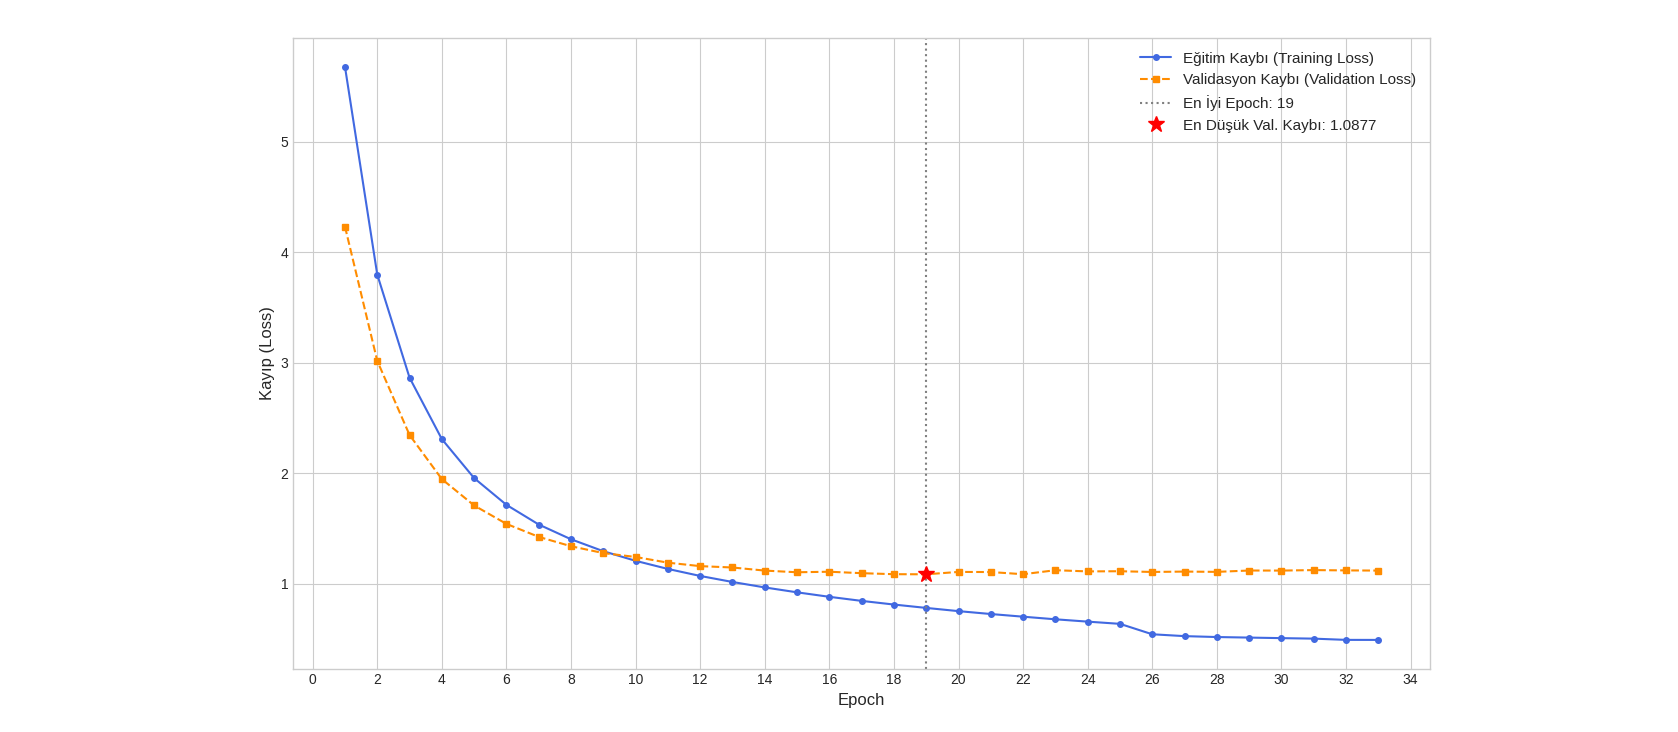

Epochlara göre eğitim ve validasyon kaybı ve LR değerleri özet tablosu olarak şöyledir.

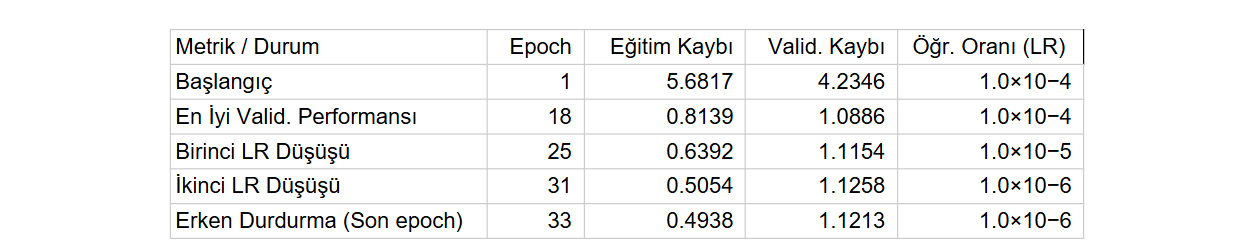

Modelin validasyon veri seti üzerindeki BLEU skoru sonuçları şöyledir.

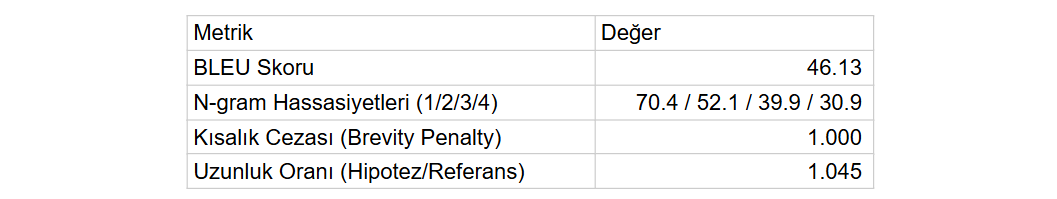